In [4]:
import pandas as pd

In [10]:
import matplotlib.pyplot as plt

In [19]:
import dhlab.graph_networkx_louvain as gnl

In [ ]:
import networkx as nx
from itertools import combinations

In [ ]:
def find_faces(G):
    # This is a naive way to find faces; there are more efficient algorithms
    cycle_generator = nx.cycle_basis(G)
    return [tuple(sorted(cycle)) for cycle in cycle_generator]

def dual_graph(G):
    faces = find_faces(G)
    G_dual = nx.Graph()
    
    for i, face1 in enumerate(faces):
        for j, face2 in enumerate(faces[i+1:], start=i+1):
            # Two faces are adjacent if they share more than one vertex
            if len(set(face1).intersection(set(face2))) > 1:
                G_dual.add_edge(i, j)
                
    return G_dual

# Create a simple square graph
G = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1), (1, 3), (2, 4)])

# Compute its dual
G_dual = dual_graph(G)

# Print the edges of the dual graph
print("Edges of the dual graph:", G_dual.edges())

In [12]:
def get_ndt():
    df = pd.read_csv('NDT/ndt_all_reduce.csv', index_col = 0)
    sent = pd.read_csv('NDT/setninger.csv', index_col = 0)
    return df, sent




def make_sentence_graph(indx):
    edges = ndt[ndt.sent_id == indx]["token_order head deprel".split()]
    nodes = ndt[ndt.sent_id == indx]["token_order form".split()]

    #edgelist = [(int(e[1].token_order), int(e[1]['head']), {'name':e[1].deprel}) for e in edges.iterrows()]
    edgelist = [(int(e[1]['head']), int(e[1].token_order), {'name':e[1].deprel}) for e in edges.iterrows()]
    nodelist = [(int(e[1].token_order), {'name':e[1]['form']}) for e in nodes.iterrows()] 

    G = nx.DiGraph()
    
    G.add_edges_from(edgelist)
    G.add_nodes_from(nodelist)
    
    # add name for root element
    G.nodes[0]['name'] = 'root'
   
    return G


def draw_graph(G, rank="BT"):
    edgelabels = {(x[0], x[1]):x[2]['name'] for x in G.edges(data=True)}
    nodelabels = {x[0]:x[1]['name'] for x in G.nodes(data=True)}
    pos =  nx.nx_agraph.graphviz_layout(G, prog="dot")
    G.graph.setdefault('graph', {})['rankdir'] = rank
    n = nx.dag_longest_path(G)
    fig = plt.figure(figsize=(16,1.4*len(n)))
    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 0, "alpha": 0.9}
    nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.3, arrows=True, edge_color='gray') #, connectionstyle="arc3,rad=0.3");
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edgelabels, font_size=8,font_color='orange');
    nx.draw_networkx_labels(G, pos, labels = nodelabels, font_color='darkblue', font_size=12);


In [7]:
ndt, sent = get_ndt()

In [56]:
Gs = [make_sentence_graph(ix+1) for ix in range(1000)]

In [57]:
Gs[0]

In [152]:
def dual_dh_style(G):
    Gd = nx.Graph()
    edges = []
    # each edge is a node
    node = 0
    for x in G.edges(data=True):
        xn = node
        Gd.add_node(node, name=x[2]['name'])
        node += 1
        for y in G.edges(data=True):
            yn = node
            Gd.add_node(node, name=y[2]['name'])
            node += 1
            if y != x:
                if x[0] == y[1] or y[0] == x[1] or x[1]==y[1] or x[0] == y[0]:
                    Gd.add_edge(xn, yn, from_nodes = (x, y))
    Gd.remove_edges_from(nx.selfloop_edges(Gd))
    return Gd

In [153]:
Gds = [dual_dh_style(G) for G in Gs]

In [160]:
from collections import Counter

In [168]:
df = pd.concat([pd.DataFrame.from_dict(
    Counter(
        [
            x['name'] for (_,_,x) in Gs[i].edges(data=True)
        ]),
    orient='index', 
    columns=[i]) for i in range(len(Gs))], axis = 1).fillna(0)

In [169]:
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
FRAG,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
KOORD,1.0,2.0,0.0,2.0,0.0,3.0,0.0,5.0,4.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
SPRED,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
IP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
KONJ,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,4.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
PUTFYLL,1.0,2.0,1.0,2.0,0.0,3.0,0.0,2.0,3.0,1.0,...,1.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,4.0
SUBJ,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,3.0,2.0
ADV,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,...,1.0,3.0,0.0,0.0,7.0,1.0,1.0,0.0,6.0,5.0
IK,0.0,1.0,1.0,5.0,2.0,2.0,2.0,4.0,5.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,1.0
FINV,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [157]:
Gds[10].nodes(data=True)

NodeDataView({0: {'name': 'ADV'}, 1: {'name': 'ADV'}, 2: {'name': 'IK'}, 3: {'name': 'KOORD'}, 4: {'name': 'FSPRED'}, 5: {'name': 'SUBJ'}, 6: {'name': 'DOBJ'}, 7: {'name': 'ADV'}, 8: {'name': 'ADV'}, 9: {'name': 'IP'}, 10: {'name': 'ADV'}, 11: {'name': 'IK'}, 12: {'name': 'FINV'}, 13: {'name': 'PUTFYLL'}, 14: {'name': 'PUTFYLL'}, 15: {'name': 'INFV'}, 16: {'name': 'DOBJ'}, 17: {'name': 'ATR'}, 18: {'name': 'PUTFYLL'}, 19: {'name': 'IK'}, 20: {'name': 'ADV'}, 21: {'name': 'IK'}, 22: {'name': 'KOORD'}, 23: {'name': 'FSPRED'}, 24: {'name': 'SUBJ'}, 25: {'name': 'DOBJ'}, 26: {'name': 'ADV'}, 27: {'name': 'ADV'}, 28: {'name': 'IP'}, 29: {'name': 'ADV'}, 30: {'name': 'IK'}, 31: {'name': 'FINV'}, 32: {'name': 'PUTFYLL'}, 33: {'name': 'PUTFYLL'}, 34: {'name': 'INFV'}, 35: {'name': 'DOBJ'}, 36: {'name': 'ATR'}, 37: {'name': 'PUTFYLL'}, 38: {'name': 'KOORD'}, 39: {'name': 'ADV'}, 40: {'name': 'IK'}, 41: {'name': 'KOORD'}, 42: {'name': 'FSPRED'}, 43: {'name': 'SUBJ'}, 44: {'name': 'DOBJ'}, 45: {'

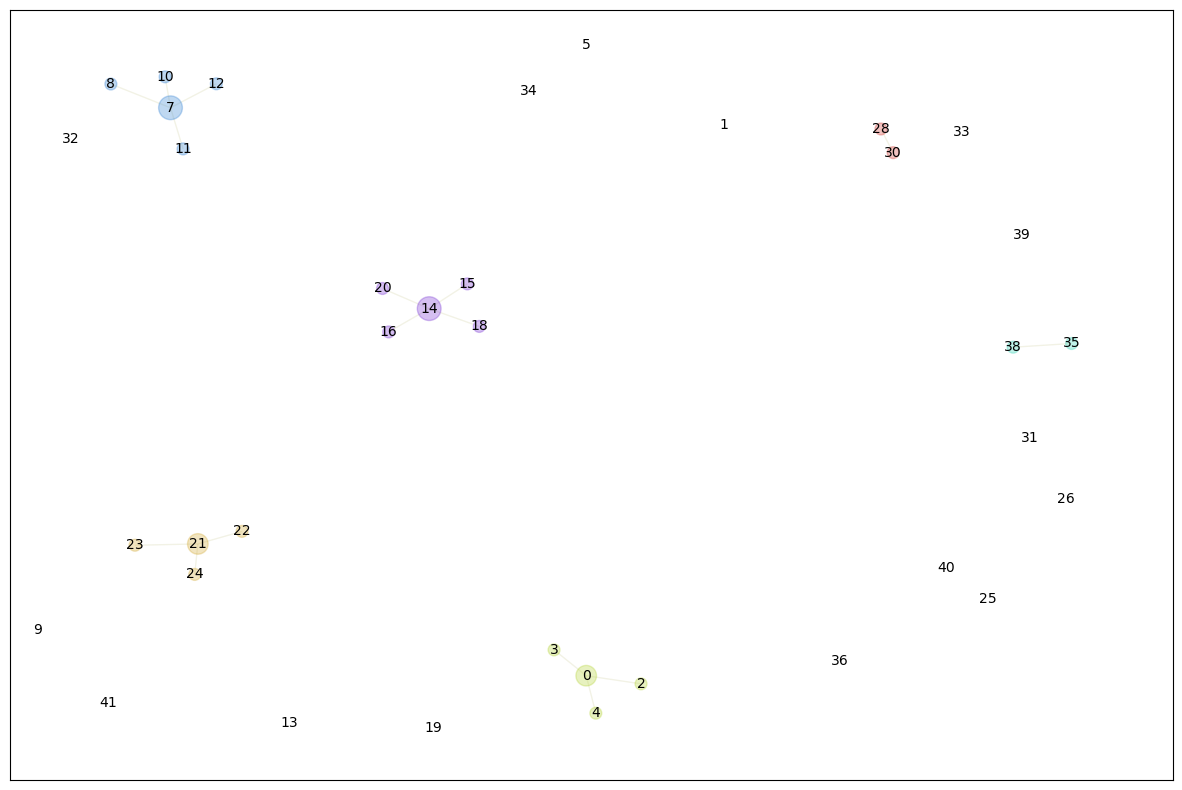

In [144]:
gnl.show_graph(Gds[0])

In [97]:
def to_frame(a_list, name='freq'):
    df = pd.DataFrame(a_list).set_index(0)
    df[name] = 1
    return df

In [100]:
outer_keys = range(100)  # Assuming this is your outer loop range

def inner_keys(G):
    return range(len(gnl.community_dict(G).values()))  # Replace this accordingly

result = pd.concat(
    [
        pd.concat(
            [to_frame(x, "") for j, x in enumerate(gnl.community_dict(Gds[i]).values())],
            axis=1,
            keys=inner_keys(Gds[i])  # Inner MultiIndex keys
        ) 
        for i in outer_keys  # Outer loop
    ],
    axis=1,
    keys=outer_keys  # Outer MultiIndex keys
).fillna(0)

In [ ]:
from sklearn.metrics.

In [170]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


# Convert DataFrame to NumPy array
data_array = df.to_numpy()

# Compute cosine similarity for rows
similarity_rows = cosine_similarity(data_array)
print("Cosine similarity between rows:")
print(similarity_rows)

# Compute cosine similarity for columns
similarity_cols = cosine_similarity(data_array.T)
print("Cosine similarity between columns:")
print(similarity_cols)


Cosine similarity between rows:
[[1.         0.0800226  0.04729434 0.34496377 0.09542465 0.10577583
  0.03473489 0.08404217 0.10395736 0.         0.07732411 0.12433922
  0.06355277 0.02118944 0.04737728 0.05153209 0.         0.03540437
  0.01337142 0.00753522 0.03094099 0.         0.02291746 0.040996
  0.         0.         0.         0.        ]
 [0.0800226  1.         0.32673848 0.49607623 0.84355359 0.55715241
  0.52096209 0.50178445 0.70912239 0.49967611 0.4587318  0.53811036
  0.38107756 0.47939337 0.35586078 0.33580924 0.1492676  0.39168294
  0.14980223 0.17516787 0.13287751 0.04447007 0.05776832 0.23423532
  0.09058615 0.0291125  0.03851221 0.        ]
 [0.04729434 0.32673848 1.         0.58053612 0.39439788 0.45821734
  0.60275737 0.51379861 0.39083621 0.60180394 0.46567781 0.44689753
  0.19103183 0.35113885 0.1919004  0.48498451 0.08652246 0.42935078
  0.09406839 0.39934565 0.2999021  0.         0.06449004 0.26149011
  0.10378766 0.01624996 0.02149668 0.        ]
 [0.34496377 

In [171]:
# Cosine similarity DataFrame for rows

similarity_df_rows = pd.DataFrame(similarity_rows, index=df.index, columns=df.index)

# Cosine similarity DataFrame for columns
similarity_df_cols = pd.DataFrame(similarity_cols, index=df.columns, columns=df.columns)


In [118]:
gnl.community_dict(Gds[72]).values()

dict_values([['SUBJ', 'INFV', 'IP', 'FINV'], ['ATR', 'PUTFYLL', 'DET'], ['ADV', 'SBU', 'DOBJ', 'IK'], ['KOORD', 'KONJ']])

In [119]:
gnl.community_dict(Gds[8]).values()

dict_values([['IK', 'PUTFYLL', 'ATR', 'KOORD'], ['KONJ', 'SUBJ', 'ADV', 'FINV', 'IP'], ['FLAT', 'APP']])

In [172]:
similarity_df_cols.sort_values(by=0,ascending=False) #.style.format(precision = 1).background_gradient()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.561951,0.421637,0.282958,0.061546,0.448111,0.123091,0.445435,0.398673,0.612372,...,0.510310,0.462910,0.612372,0.471405,0.151911,0.129099,0.182574,0.144338,0.282843,0.398527
934,0.816497,0.458831,0.387298,0.198030,0.075378,0.329293,0.075378,0.436436,0.366205,0.500000,...,0.375000,0.283473,0.500000,0.577350,0.062017,0.158114,0.223607,0.176777,0.173205,0.162698
20,0.816497,0.458831,0.387298,0.198030,0.075378,0.329293,0.075378,0.436436,0.366205,0.500000,...,0.375000,0.283473,0.500000,0.577350,0.062017,0.158114,0.223607,0.176777,0.173205,0.162698
658,0.730297,0.512989,0.461880,0.177123,0.134840,0.343616,0.134840,0.195180,0.181969,0.894427,...,0.447214,0.591608,0.670820,0.516398,0.554700,0.282843,0.400000,0.158114,0.516398,0.582086
27,0.721688,0.567775,0.365148,0.385077,0.159901,0.426883,0.159901,0.655789,0.517892,0.353553,...,0.441942,0.334077,0.353553,0.408248,0.043853,0.223607,0.316228,0.375000,0.326599,0.191741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,0.072169,0.527220,0.136931,0.612623,0.186551,0.698535,0.159901,0.559350,0.374033,0.176777,...,0.662913,0.467707,0.088388,0.510310,0.460455,0.559017,0.474342,0.312500,0.510310,0.728617
357,0.070014,0.550823,0.265684,0.101885,0.232689,0.263542,0.103418,0.018712,0.125607,0.514496,...,0.428746,0.680614,0.085749,0.099015,0.872143,0.705024,0.690268,0.181902,0.811921,0.651057
848,0.064550,0.580381,0.244949,0.563602,0.262202,0.607434,0.190693,0.465794,0.373147,0.316228,...,0.711512,0.597614,0.079057,0.365148,0.627572,0.750000,0.636396,0.391312,0.766812,0.754594
4,0.061546,0.242100,0.856349,0.641863,1.000000,0.148928,0.977273,0.148039,0.760636,0.150756,...,0.452267,0.256411,0.075378,0.087039,0.186989,0.333712,0.404520,0.319801,0.330748,0.179869


In [ ]:
# Collapse rows (index)
df = similarity_df_cols
collapsed_df_rows = df.groupby(level=0).mean()

# Collapse columns
collapsed_df = collapsed_df_rows.groupby(level=0, axis=1).mean()

print("Collapsed DataFrame:")

In [125]:
collapsed_df.style.format(precision=2).background_gradient()

In [126]:
gnl.community_dict(Gds[11])

{'KOORD-PUTFYLL': ['KOORD', 'PUTFYLL', 'ATR', 'KONJ'],
 'IK-SUBJ': ['IK', 'SUBJ', 'ADV', 'FINV', 'IP', 'APP']}

In [127]:
gnl.community_dict(Gds[18])

{'PUTFYLL-ATR': ['PUTFYLL', 'ATR', 'DET'],
 'ADV-FINV': ['ADV', 'FINV', 'FSUBJ', 'IP', 'SPRED'],
 'PSUBJ-INFV': ['PSUBJ', 'INFV', 'SUBJ', 'SBU']}